## Homework


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

### Loading data


In [70]:
def load_csv():
    df = pd.read_csv("bank-full.csv", sep=";")
    return df


df = load_csv()
df.head().T

features = [
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y",
]

df = df[features]

df.y = (df.y == "yes").astype(int)
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5
month,may,may,may,may,may
duration,261,151,76,92,198


In [71]:
for feature in features:
    print("")
    print(feature, " ", df[feature].dtype)
    print("", df[feature].unique())
    print("", df[feature].nunique())



age   int64
 [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
 77

job   object
 ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
 12

marital   object
 ['married' 'single' 'divorced']
 3

education   object
 ['tertiary' 'secondary' 'unknown' 'primary']
 4

balance   int64
 [ 2143    29     2 ...  8205 14204 16353]
 7168

housing   object
 ['yes' 'no']
 2

contact   object
 ['unknown' 'cellular' 'telephone']
 3

day   int64
 [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
 31

month   object
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
 12

duration   int64
 [ 261  151   76 ... 1298 1246 1556]
 1573

campaign   int64
 [ 1  2 

In [72]:
numerical = [
    "age",
    "balance",
    "day",
    "duration",
    "campaign",
    "pdays",
    "previous",
]

categorical = [    
    "job",
    "marital",
    "education",    
    "housing",
    "contact",    
    "month",                
    "poutcome",    
]

set(features) == set(numerical + categorical + ["y"])


True

### Dataset preparation


In [73]:
from sklearn.model_selection import train_test_split


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df.shape[0], df_train.shape[0], df_val.shape[0], df_test.shape[0], df_train.shape[
    0
] + df_val.shape[0] + df_test.shape[0]

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.y.values
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_full_train["y"]
del df_train["y"]
del df_val["y"]
del df_test["y"]

df_train.head().T

,0,1,2,3,4
age,56,33,32,40,54
job,entrepreneur,technician,technician,admin.,unemployed
marital,married,married,single,divorced,married
education,tertiary,secondary,tertiary,secondary,tertiary
balance,40,4790,392,2129,1180
housing,no,yes,yes,no,no
contact,cellular,cellular,cellular,cellular,cellular
day,11,20,21,30,19
month,jul,apr,nov,apr,nov
duration,123,137,148,452,394


## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
  Use the training dataset for that
- If your AUC is < 0.5, invert this variable by putting "-" in front

> (e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous


[('duration', 0.8147002759670778),
 ('previous', 0.5985653242764153),
 ('balance', 0.5888313805382317),
 ('day', 0.525957882383908)]

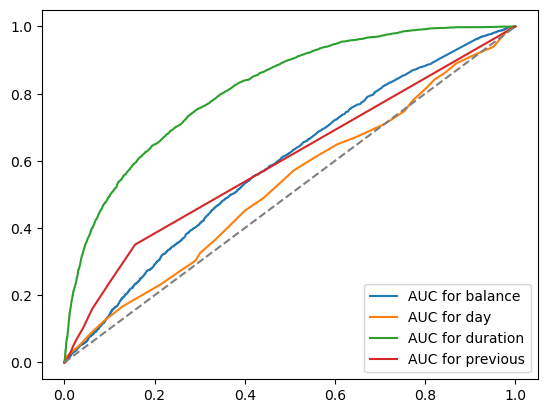

In [74]:
answers = [
    "balance",
    "day",
    "duration",
    "previous"
]

scores = {}

def calculate_auc(df_train, feature, invert=False):
    if invert:
        y_pred = -df_train[feature].values
    else:
        y_pred = df_train[feature].values
    score = roc_auc_score(y_train, y_pred)
    if score < 0.5 and not invert:        
        return calculate_auc(df_train, feature, invert=True)        
    return score, y_pred

for feature in answers:    
    score, y_pred = calculate_auc(df_train, feature)
    scores[feature] = score
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    plt.plot(fpr, tpr, label=f"AUC for {feature}")
    
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel("feature")
# plt.ylabel("y")
plt.legend()


sorted_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
sorted_scores

# Answer is `duration``

### Question 1: tests


In [75]:
train_features = categorical + numerical 

train_dicts = df_train[train_features].to_dict(orient='records')
train_dicts
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[train_features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
sub_pred = (y_pred >= 0.5).astype(int)
# Accuracy
accuracy = round((sub_pred == y_val).mean(), 2)
accuracy


/usr/local/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.89

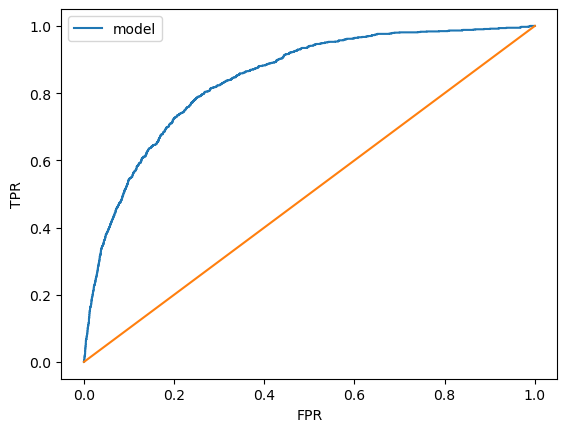

In [76]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.plot(fpr, tpr, label="model")
plt.plot([0, 1], [0, 1])


plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

In [77]:
auc(fpr, tpr)

0.8419658236067775

In [78]:
roc_auc_score(y_val, y_pred)

0.8419658236067775

In [79]:
numerical

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [80]:
def train(df, y_train, train_features):
    dicts = df[train_features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    model = LogisticRegression()
    model.fit(X, y_train)
    return dv, model

def predict(df, dv, model, train_features):
    dicts = df[train_features].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

scores = {}

for n in numerical:
    dv, model = train(df_train, y_train, [n])
    y_pred = predict(df_val, dv, model, [n])
    score = roc_auc_score(y_val, y_pred)
    scores[n] = score

sorted_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
sorted_scores    

[('duration', 0.7965344730967409),
 ('previous', 0.607255799705406),
 ('balance', 0.5995068851725284),
 ('pdays', 0.596249681284474),
 ('campaign', 0.5762433459535511),
 ('day', 0.5352198426324892),
 ('age', 0.5019686989252637)]

In [81]:
scores = {}

for n in numerical:
    dv, model = train(df_full_train, y_full_train, [n])
    y_pred = predict(df_val, dv, model, [n])

    score = roc_auc_score(y_val, y_pred)
    scores[n] = score

sorted_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
sorted_scores    


[('duration', 0.7965344730967409),
 ('previous', 0.607255799705406),
 ('balance', 0.5995068851725284),
 ('pdays', 0.596249681284474),
 ('campaign', 0.5762433459535511),
 ('day', 0.5352198426324892),
 ('age', 0.5019686989252637)]

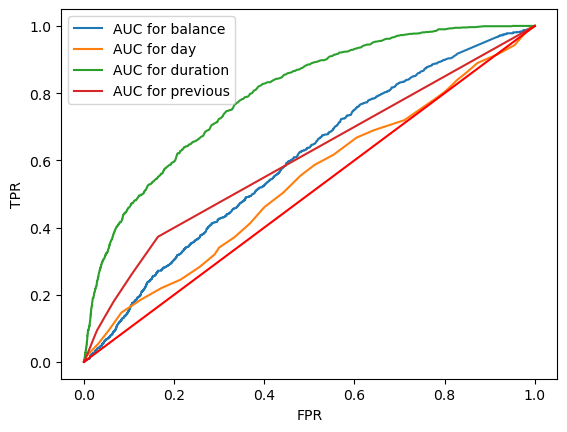

In [82]:
answers = [
    "balance",
    "day",
    "duration",
    "previous"
]

for n in answers:
    dv, model = train(df_full_train, y_full_train, [n])
    y_pred = predict(df_val, dv, model, [n])

    fpr, tpr, thresholds = roc_curve(y_val, y_pred)

    plt.plot(fpr, tpr, label=f"AUC for {n}")
    

plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

> LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99


In [83]:
def train(df, y_train, features, C):    
    dicts = df[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y_train)
    return dv, model

def predict(df, dv, model, features):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

train_features = categorical + numerical
dv, model = train(df_train, y_train, train_features, C=1.0)
y_pred = predict(df_val, dv, model, train_features)
y_pred_int = (y_pred >= 0.5).astype(int)
accuracy = (y_pred_int == y_val).mean()
accuracy

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
fpr, tpr, thresholds

auc(fpr, tpr), roc_auc_score(y_val, y_pred)

# Answer is `0.89`


(0.8999653998756322, 0.8999653998756322)

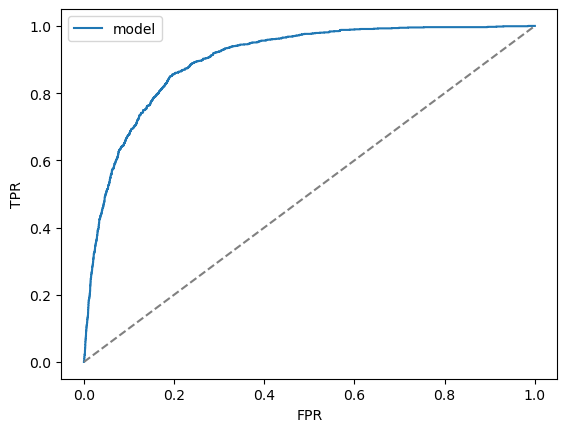

In [84]:
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

#@ Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865


In [85]:
thresholds = [0.5]

def evaluate_model(thresholds):
    scores = []
    for t in thresholds:
        train_features = categorical + numerical
        dv, model = train(df_train, y_train, train_features, C=1.0)
        y_pred = predict(df_val, dv, model, train_features)

        pos_pred = (y_pred >= t)
        neg_pred = (y_pred < t)
        act_pos = (y_val == 1)
        act_neg = (y_val == 0)

        tp = (pos_pred & act_pos).sum()
        tn = (neg_pred & act_neg).sum()
        fp = (pos_pred & act_neg).sum()
        fn = (neg_pred & act_pos).sum()
        scores.append((t, tp, tn, fp, fn))
    return scores
    
t, tp, tn, fp, fn = evaluate_model(thresholds)[0]
# Check if the len is the same
len(y_val), tp + tn + fp + fn

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp],
])

(confusion_matrix / confusion_matrix.sum()).round(2)


array([[0.86, 0.02],
       [0.08, 0.04]])

In [ ]:
thresholds = np.linspace(0, 1, 100).round(2)
evalutes = evaluate_model(thresholds)
evalutes

In [248]:
df_evaluted = pd.DataFrame(evalutes, columns=["threshold", "tp", "tn", "fp", "fn"])
df_evaluted["precision"] = df_evaluted.tp / (df_evaluted.tp + df_evaluted.fp)
df_evaluted["precision"] = df_evaluted["precision"].fillna(1)
df_evaluted["recall"] = df_evaluted.tp / (df_evaluted.tp + df_evaluted.fn)
df_evaluted["diff"] = np.abs(df_evaluted.precision - df_evaluted.recall)

df_evaluted



,threshold,tp,tn,fp,fn,precision,recall,diff
0,0.00,1098,0,7944,0,0.121433,1.000000,0.878567
1,0.01,1094,988,6956,4,0.135901,0.996357,0.860456
2,0.02,1093,2176,5768,5,0.159306,0.995446,0.836140
3,0.03,1086,3206,4738,12,0.186470,0.989071,0.802601
4,0.04,1067,4166,3778,31,0.220227,0.971767,0.751540
...,...,...,...,...,...,...,...,...
95,0.96,32,7927,17,1066,0.653061,0.029144,0.623917
96,0.97,25,7929,15,1073,0.625000,0.022769,0.602231
97,0.98,22,7934,10,1076,0.687500,0.020036,0.667464
98,0.99,10,7938,6,1088,0.625000,0.009107,0.615893


In [252]:
idx_min = df_evaluted["diff"].idxmin()
intersection_threshold = df_evaluted.iloc[idx_min].threshold
idx_min, intersection_threshold

# Answer is `0.265`

(27, 0.27)

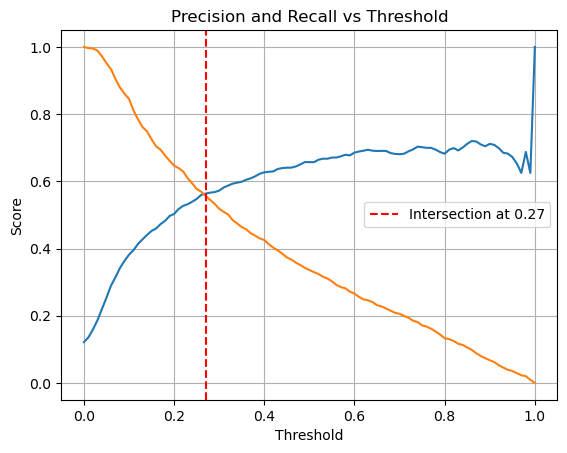

In [254]:
plt.plot(df_evaluted["threshold"], df_evaluted["precision"])
plt.plot(df_evaluted["threshold"], df_evaluted["recall"])
plt.axvline(x=intersection_threshold, color='r', linestyle='--', label=f'Intersection at {intersection_threshold:.2f}')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

![alt text](images/image_1.png "Title")

Where
P
is precision and
R
is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62


In [262]:
df_f1 = pd.DataFrame(evalutes, columns=["threshold", "tp", "tn", "fp", "fn"])
df_f1["precision"] = df_f1.tp / (df_f1.tp + df_f1.fp)
df_f1["precision"] = df_f1["precision"].fillna(1)
df_f1["recall"] = df_f1.tp / (df_f1.tp + df_f1.fn)
df_f1["f1"] = 2 * ((df_f1.precision * df_f1.recall) / (df_f1.precision + df_f1.recall))
df_f1

,threshold,tp,tn,fp,fn,precision,recall,f1
0,0.00,1098,0,7944,0,0.121433,1.000000,0.216568
1,0.01,1094,988,6956,4,0.135901,0.996357,0.239178
2,0.02,1093,2176,5768,5,0.159306,0.995446,0.274658
3,0.03,1086,3206,4738,12,0.186470,0.989071,0.313782
4,0.04,1067,4166,3778,31,0.220227,0.971767,0.359078
...,...,...,...,...,...,...,...,...
95,0.96,32,7927,17,1066,0.653061,0.029144,0.055798
96,0.97,25,7929,15,1073,0.625000,0.022769,0.043937
97,0.98,22,7934,10,1076,0.687500,0.020036,0.038938
98,0.99,10,7938,6,1088,0.625000,0.009107,0.017953


In [263]:
df_f1.isnull().sum()

threshold    0
tp           0
tn           0
fp           0
fn           0
precision    0
recall       0
f1           0
dtype: int64

In [265]:
idx_max = df_f1["f1"].idxmax()
f1_max_threshold = df_f1.iloc[idx_max].threshold
idx_max, f1_max_threshold, df_f1.iloc[idx_max].f1

(22, 0.22, 0.5736820257368203)

/var/folders/wq/xxr4ff9s1hg945mqypn203yskzqq0j/T/ipykernel_72510/914940413.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


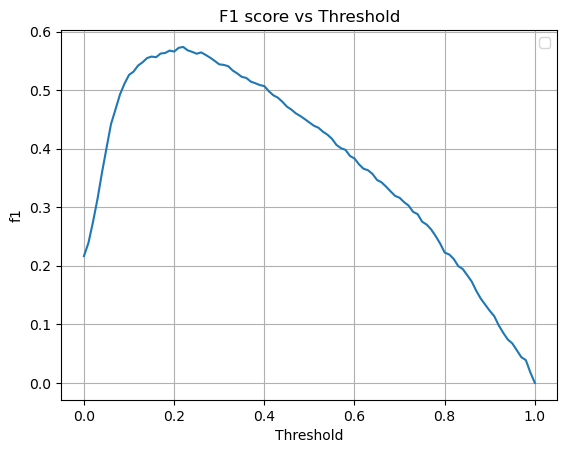

In [260]:
plt.plot(df_f1["threshold"], df_f1["f1"])
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Answer is `0.22`

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26


In [48]:
from turtle import mode
from sklearn.model_selection import KFold

def train_full(df, y_train, C=1.0):
    dicts = df.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict_full(df, dv, model):
    dicts = df.to_dict(orient="records")
    X_val = dv.transform(dicts)
    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

def evaluate_model(C, n_splits = 5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, test_idx in kfold.split(df_full_train):    
        df_train_kfold = df_full_train.iloc[train_idx]
        df_val_kfold = df_full_train.iloc[test_idx]

        y_train_kfold = y_full_train[train_idx]
        y_val_kfold = y_full_train[test_idx]
        
        dv, model = train_full(df_train_kfold, y_train_kfold, C)
        y_pred = predict_full(df_val_kfold, dv, model)

        score = roc_auc_score(y_val_kfold, y_pred)
        scores.append(score)

    return scores

scores = evaluate_model(C=1.0)
scores

[0.8991066306040488,
 0.8988958506935749,
 0.911149576951329,
 0.9079748009686723,
 0.9120918352270209]

In [49]:
round(np.std(scores), 3)

# Answer is `0.006`

0.006

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.


In [54]:
C = [0.000001, 0.001, 1]

for c_value in C:
    scores = evaluate_model(c_value)
    std = np.std(scores)
    mean = np.mean(scores)
    print(f"C: {c_value}, mean: {mean:3f} std: {std:3f}" )

# Answer is `1`

C: 1e-06, mean: 0.701445 std: 0.009444
C: 0.001, mean: 0.861053 std: 0.006623
C: 1, mean: 0.905844 std: 0.005751
